In [12]:
from bayes_implicit_solvent.continuous_parameter_experiments.gradient_free import mols

In [13]:
# THE CODE IN THIS CELL IS ADAPTED FROM https://github.com/HIPS/neural-fingerprint
# ACCOMPANYING "Convolutional Networks on Graphs for Learning Molecular Fingerprints"
# by David Duvenaud, Dougal Maclaurin, Jorge Aguilera-Iparraguirre, Rafael Gómez-Bombarelli, Timothy Hirzel, Alán Aspuru-Guzik, and Ryan P. Adams.

import autograd.numpy as np
from rdkit import Chem

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

#def atom_features_rdkit(atom):
#    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
#                                      ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na',
#                                       'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb',
#                                       'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H',    # H?
#                                       'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr',
#                                       'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
#                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
#                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
#                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
#                    [atom.GetIsAromatic()] + 
#                   )


def atom_features(atom):
    """Use some OpenEye features instead"""
    return np.array(one_of_k_encoding_unk(atom.GetAtomicNum(),
                                      [1, 35, 6, 7, 8, 9, 15, 16, 17, 53, -1]) +
                    one_of_k_encoding(atom.GetDegree(), [1, 2, 3, 4]) +
                    one_of_k_encoding(atom.GetValence(), [1, 2, 3, 4, 5, 6]) +
                    one_of_k_encoding(atom.GetHvyValence(), [0, 1, 2, 3, 4, 5, 6]) +
                    one_of_k_encoding(atom.GetHvyDegree(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding(atom.GetTotalHCount(), [0, 1, 2, 3, 4]) +
                    [atom.GetPartialCharge()] + # float features
                    [atom.IsAromatic(), atom.IsHalogen(), atom.IsPolarHydrogen(), atom.IsMetal(), atom.IsInRing()] # binary features
                   )

#def bond_features_rdkit(bond):
#    bt = bond.GetBondType()
#    return np.array([bt == Chem.rdchem.BondType.SINGLE,
#                     bt == Chem.rdchem.BondType.DOUBLE,
#                     bt == Chem.rdchem.BondType.TRIPLE,
#                     bt == Chem.rdchem.BondType.AROMATIC,
#                     bond.GetIsConjugated(),
#                     bond.IsInRing()])

def bond_features(bond):
    """Use OpenEye features instead"""
    return np.array(one_of_k_encoding(bond.GetOrder(), [1, 2, 3]) +
                    [bond.IsAromatic(), bond.IsInRing(), bond.IsRotor()] # binary features
                   )
    

def num_atom_features():
    atoms = list(mols[0].mol.GetAtoms())
    return len(atom_features(atoms[0]))


def num_bond_features():
    bonds = list(mols[0].mol.GetBonds())
    return len(bond_features(bonds[0]))


In [14]:
num_atom_features(), num_bond_features()

(44, 6)

In [15]:
# THE CODE IN THIS CELL IS ADAPTED FROM https://github.com/HIPS/neural-fingerprint
# ACCOMPANYING "Convolutional Networks on Graphs for Learning Molecular Fingerprints"
# by David Duvenaud, Dougal Maclaurin, Jorge Aguilera-Iparraguirre, Rafael Gómez-Bombarelli, Timothy Hirzel, Alán Aspuru-Guzik, and Ryan P. Adams.

import numpy as np

degrees = [0, 1, 2, 3, 4, 5]
#degrees = [0]

class MolGraph(object):
    def __init__(self):
        self.nodes = {} # dict of lists of nodes, keyed by node type

    def new_node(self, ntype, features=None, rdkit_ix=None):
        new_node = Node(ntype, features, rdkit_ix)
        self.nodes.setdefault(ntype, []).append(new_node)
        return new_node

    def add_subgraph(self, subgraph):
        old_nodes = self.nodes
        new_nodes = subgraph.nodes
        for ntype in set(old_nodes.keys()) | set(new_nodes.keys()):
            old_nodes.setdefault(ntype, []).extend(new_nodes.get(ntype, []))

    def sort_nodes_by_degree(self, ntype):
        nodes_by_degree = {i : [] for i in degrees}
        for node in self.nodes[ntype]:
            nodes_by_degree[len(node.get_neighbors(ntype))].append(node)

        new_nodes = []
        for degree in degrees:
            cur_nodes = nodes_by_degree[degree]
            self.nodes[(ntype, degree)] = cur_nodes
            new_nodes.extend(cur_nodes)

        self.nodes[ntype] = new_nodes

    def feature_array(self, ntype):
        assert ntype in self.nodes
        return np.array([node.features for node in self.nodes[ntype]])

    def rdkit_ix_array(self):
        return np.array([node.rdkit_ix for node in self.nodes['atom']])

    def neighbor_list(self, self_ntype, neighbor_ntype):
        assert self_ntype in self.nodes and neighbor_ntype in self.nodes
        neighbor_idxs = {n : i for i, n in enumerate(self.nodes[neighbor_ntype])}
        return [[neighbor_idxs[neighbor]
                 for neighbor in self_node.get_neighbors(neighbor_ntype)]
                for self_node in self.nodes[self_ntype]]

class Node(object):
    __slots__ = ['ntype', 'features', '_neighbors', 'rdkit_ix']
    def __init__(self, ntype, features, rdkit_ix):
        self.ntype = ntype
        self.features = features
        self._neighbors = []
        self.rdkit_ix = rdkit_ix

    def add_neighbors(self, neighbor_list):
        for neighbor in neighbor_list:
            self._neighbors.append(neighbor)
            neighbor._neighbors.append(self)

    def get_neighbors(self, ntype):
        return [n for n in self._neighbors if n.ntype == ntype]

#def graph_from_smiles_tuple(smiles_tuple):
#    graph_list = [graph_from_smiles(s) for s in smiles_tuple]
#    big_graph = MolGraph()
#    for subgraph in graph_list:
#        big_graph.add_subgraph(subgraph)
#
#    # This sorting allows an efficient (but brittle!) indexing later on.
#    big_graph.sort_nodes_by_degree('atom')
#    return big_graph
#
#def graph_from_smiles(smiles):
#    graph = MolGraph()
#    mol = MolFromSmiles(smiles)
#    if not mol:
#        raise ValueError("Could not parse SMILES string:", smiles)
#    atoms_by_rd_idx = {}
#   for atom in mol.GetAtoms():
#        new_atom_node = graph.new_node('atom', features=atom_features(atom), rdkit_ix=atom.GetIdx())
#        atoms_by_rd_idx[atom.GetIdx()] = new_atom_node
#
#    for bond in mol.GetBonds():
#        atom1_node = atoms_by_rd_idx[bond.GetBeginAtom().GetIdx()]
#        atom2_node = atoms_by_rd_idx[bond.GetEndAtom().GetIdx()]
#        new_bond_node = graph.new_node('bond', features=bond_features(bond))
#        new_bond_node.add_neighbors((atom1_node, atom2_node))
#        atom1_node.add_neighbors((atom2_node,))
#
#    mol_node = graph.new_node('molecule')
#    mol_node.add_neighbors(graph.nodes['atom'])
#    return graph

In [16]:
def graph_from_mol_tuple(mol_tuple):
    graph_list = [graph_from_mol(m) for m in mol_tuple]
    big_graph = MolGraph()
    for subgraph in graph_list:
        big_graph.add_subgraph(subgraph)

    # This sorting allows an efficient (but brittle!) indexing later on.
    big_graph.sort_nodes_by_degree('atom')
    return big_graph

def graph_from_mol(oemol):
    graph = MolGraph()
    atoms_by_rd_idx = {}
    for atom in oemol.GetAtoms():
        new_atom_node = graph.new_node('atom', features=atom_features(atom), rdkit_ix=atom.GetIdx())
        atoms_by_rd_idx[atom.GetIdx()] = new_atom_node

    for bond in oemol.GetBonds():
        atom1_node = atoms_by_rd_idx[bond.GetBgn().GetIdx()]
        atom2_node = atoms_by_rd_idx[bond.GetEnd().GetIdx()]
        new_bond_node = graph.new_node('bond', features=bond_features(bond))
        new_bond_node.add_neighbors((atom1_node, atom2_node))
        atom1_node.add_neighbors((atom2_node,))

    mol_node = graph.new_node('molecule')
    mol_node.add_neighbors(graph.nodes['atom'])
    return graph

In [17]:
# THE CODE IN THIS CELL IS ADAPTED FROM https://github.com/HIPS/neural-fingerprint
# ACCOMPANYING "Convolutional Networks on Graphs for Learning Molecular Fingerprints"
# by David Duvenaud, Dougal Maclaurin, Jorge Aguilera-Iparraguirre, Rafael Gómez-Bombarelli, Timothy Hirzel, Alán Aspuru-Guzik, and Ryan P. Adams.

from functools import partial
from collections import OrderedDict

class memoize(object):
    def __init__(self, func):
        self.func = func
        self.cache = {}

    def __call__(self, *args):
        if args in self.cache:
            return self.cache[args]
        else:
            result = self.func(*args)
            self.cache[args] = result
            return result

    def __get__(self, obj, objtype):
        return partial(self.__call__, obj)

class WeightsParser(object):
    """A kind of dictionary of weights shapes,
       which can pick out named subsets from a long vector.
       Does not actually store any weights itself."""
    def __init__(self):
        self.idxs_and_shapes = OrderedDict()
        self.N = 0

    def add_weights(self, name, shape):
        start = self.N
        self.N += np.prod(shape)
        self.idxs_and_shapes[name] = (slice(start, self.N), shape)

    def get(self, vect, name):
        """Takes in a vector and returns the subset indexed by name."""
        idxs, shape = self.idxs_and_shapes[name]
        return np.reshape(vect[idxs], shape)

    def set(self, vect, name, value):
        """Takes in a vector and returns the subset indexed by name."""
        idxs, _ = self.idxs_and_shapes[name]
        vect[idxs] = np.ravel(value)

    def __len__(self):
        return self.N

In [18]:
# THE CODE IN THIS CELL IS ADAPTED FROM https://github.com/HIPS/neural-fingerprint
# ACCOMPANYING "Convolutional Networks on Graphs for Learning Molecular Fingerprints"
# by David Duvenaud, Dougal Maclaurin, Jorge Aguilera-Iparraguirre, Rafael Gómez-Bombarelli, Timothy Hirzel, Alán Aspuru-Guzik, and Ryan P. Adams.


import autograd.numpy as np
from autograd.scipy.misc import logsumexp

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def relu(X):
    "Rectified linear activation function."
    return X * (X > 0)

def fast_array_from_list(xs):
    return np.concatenate([np.expand_dims(x, axis=0) for x in xs], axis=0)

def sum_and_stack(features, idxs_list_of_lists):
    return fast_array_from_list([np.sum(features[idx_list], axis=0) for idx_list in idxs_list_of_lists])

def softmax(X, axis=0):
    return np.exp(X - logsumexp(X, axis=axis, keepdims=True))

def matmult_neighbors(array_rep, atom_features, bond_features, get_weights):
    activations_by_degree = []
    for degree in degrees:
        atom_neighbors_list = array_rep[('atom_neighbors', degree)]
        bond_neighbors_list = array_rep[('bond_neighbors', degree)]
        if len(atom_neighbors_list) > 0:
            neighbor_features = [atom_features[atom_neighbors_list],
                                 bond_features[bond_neighbors_list]]
            # dims of stacked_neighbors are [atoms, neighbors, atom and bond features]
            stacked_neighbors = np.concatenate(neighbor_features, axis=2)
            summed_neighbors = np.sum(stacked_neighbors, axis=1)
            activations = np.dot(summed_neighbors, get_weights(degree))
            activations_by_degree.append(activations)
    # This operation relies on atoms being sorted by degree,
    # in Node.graph_from_smiles_tuple()
    return np.concatenate(activations_by_degree, axis=0)

def weights_name(layer, degree):
    return "layer " + str(layer) + " degree " + str(degree) + " filter"

def build_convnet_fingerprint_fun(num_hidden_features=[100, 100], fp_length=512,
                                  normalize=True, activation_function=relu):
    """Sets up functions to compute convnets over all molecules in a minibatch together."""

    # Specify weight shapes.
    parser = WeightsParser()
    all_layer_sizes = [num_atom_features()] + num_hidden_features
    for layer in range(len(all_layer_sizes)):
        parser.add_weights(('layer output weights', layer), (all_layer_sizes[layer], fp_length))
        parser.add_weights(('layer output bias', layer),    (1, fp_length))

    in_and_out_sizes = zip(all_layer_sizes[:-1], all_layer_sizes[1:])
    for layer, (N_prev, N_cur) in enumerate(in_and_out_sizes):
        parser.add_weights(("layer", layer, "biases"), (1, N_cur))
        parser.add_weights(("layer", layer, "self filter"), (N_prev, N_cur))
        for degree in degrees:
            parser.add_weights(weights_name(layer, degree), (N_prev + num_bond_features(), N_cur))

    def update_layer(weights, layer, atom_features, bond_features, array_rep, normalize=False):
        def get_weights_func(degree):
            return parser.get(weights, weights_name(layer, degree))
        layer_bias         = parser.get(weights, ("layer", layer, "biases"))
        layer_self_weights = parser.get(weights, ("layer", layer, "self filter"))
        self_activations = np.dot(atom_features, layer_self_weights)
        neighbour_activations = matmult_neighbors(
            array_rep, atom_features, bond_features, get_weights_func)

        total_activations = neighbour_activations + self_activations + layer_bias
        if normalize:
            total_activations = batch_normalize(total_activations)
        return activation_function(total_activations)

    def output_layer_fun_and_atom_activations(weights, mol):
        """Computes layer-wise convolution, and returns a fixed-size output."""

        array_rep = array_rep_from_mol(tuple(mol))
        atom_features = array_rep['atom_features']
        bond_features = array_rep['bond_features']

        all_layer_fps = []
        atom_activations = []
        def write_to_fingerprint(atom_features, layer):
            cur_out_weights = parser.get(weights, ('layer output weights', layer))
            cur_out_bias    = parser.get(weights, ('layer output bias', layer))
            atom_outputs = softmax(cur_out_bias + np.dot(atom_features, cur_out_weights), axis=1)
            atom_activations.append(atom_outputs)
            # Sum over all atoms within a moleclue:
            layer_output = sum_and_stack(atom_outputs, array_rep['atom_list'])
            all_layer_fps.append(layer_output)

        num_layers = len(num_hidden_features)
        for layer in range(num_layers):
            write_to_fingerprint(atom_features, layer)
            atom_features = update_layer(weights, layer, atom_features, bond_features, array_rep,
                                         normalize=normalize)
        write_to_fingerprint(atom_features, num_layers)
        return sum(all_layer_fps), atom_activations, array_rep, atom_features

    def output_layer_fun(weights, smiles):
        output, _, _, _ = output_layer_fun_and_atom_activations(weights, smiles)
        return output

    def compute_atom_activations(weights, smiles):
        _, atom_activations, array_rep, _ = output_layer_fun_and_atom_activations(weights, smiles)
        return atom_activations, array_rep
    
    def compute_atom_features(weights, smiles):
        _, _, _, atom_features = output_layer_fun_and_atom_activations(weights, smiles)
        return atom_features

    return output_layer_fun, parser, compute_atom_activations, compute_atom_features

@memoize
def array_rep_from_mol(mol):
    """Precompute everything we need from MolGraph so that we can free the memory asap."""
    molgraph = graph_from_mol_tuple(mol)
    arrayrep = {'atom_features' : molgraph.feature_array('atom'),
                'bond_features' : molgraph.feature_array('bond'),
                'atom_list'     : molgraph.neighbor_list('molecule', 'atom'), # List of lists.
                'rdkit_ix'      : molgraph.rdkit_ix_array()}  # For plotting only.
    for degree in degrees:
        arrayrep[('atom_neighbors', degree)] = \
            np.array(molgraph.neighbor_list(('atom', degree), 'atom'), dtype=int)
        arrayrep[('bond_neighbors', degree)] = \
            np.array(molgraph.neighbor_list(('atom', degree), 'bond'), dtype=int)
    return arrayrep

In [19]:
output_layer_fun, parser, compute_atom_activations, compute_atom_features = build_convnet_fingerprint_fun(
    #num_hidden_features=[100,100,2],
    num_hidden_features=[2],
    fp_length=1,
    normalize=True,
    activation_function=relu)

In [20]:
parser.N

738

In [21]:
weights = 0.01 * np.random.randn(parser.N)

In [22]:
compute_atom_features(weights, (mols[0].mol,)) == 0

array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [False, False],
       [False, False],
       [ True,  True],
       [ True, False],
       [False, False]])

In [23]:
computed_features = compute_atom_features(weights, (mols[0].mol,))

In [24]:
computed_features.shape

(17, 2)

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
from bayes_implicit_solvent.utils import get_charges
from scipy.spatial.distance import pdist, squareform
from simtk import unit
elements = []
charges = []
distance_matrices = []
expt_means = []
expt_uncs = []
vacuum_trajs = []
for mol in mols:
    expt_means.append(mol.experimental_value)
    expt_uncs.append(mol.experimental_uncertainty)

    elements.append(np.array([a.element.atomic_number for a in mol.top.atoms()]))
    charges.append(get_charges(mol.sys))
    distance_matrices.append([squareform(pdist(snapshot / unit.nanometer)) for snapshot in mol.vacuum_traj])

In [27]:
N_atoms = np.array(list(map(len, charges)))

In [28]:
len(mols)

642

In [29]:
array_rep_from_mol((mols[0].mol,))

{'atom_features': array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.1023    ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        

In [30]:
array_rep_from_mol((mols[0].mol,))

{'atom_features': array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.1023    ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        

In [31]:
from tqdm import tqdm

okay_inds = []
for i in range(len(mols)):
    try:
        array_rep_from_mol((mols[i].mol,))
        okay_inds.append(i)
    except AssertionError:
        print('problem encountered for {}!'.format(mol.mol))
    #_ = array_rep_from_smiles((smiles,))

In [32]:
okay_inds = np.array(okay_inds)

In [33]:
np.random.seed(0)
train_inds = np.array(okay_inds)
np.random.shuffle(train_inds)
train_inds = train_inds[::2]

In [34]:
train_mols = tuple(mols[i].mol for i in train_inds)

In [35]:
computed_features = compute_atom_features(weights, train_mols)

In [36]:
train_sizes = [len(array_rep_from_mol((mol,))['atom_list'][0]) for mol in train_mols]
sum(train_sizes)

5729

In [37]:
train_sizes = [len(array_rep_from_mol((mol,))['atom_features']) for mol in train_mols]
sum(train_sizes)

5729

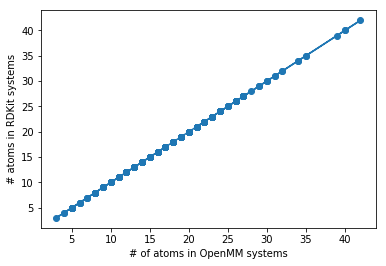

In [38]:
plt.scatter(N_atoms[train_inds], train_sizes)
plt.xlabel('# of atoms in OpenMM systems')
plt.ylabel('# atoms in RDKit systems')
plt.plot(train_sizes, train_sizes)

In [39]:
computed_features.shape

(5729, 2)

In [40]:
# initialize near sensible values, rather than initialize at very small magnitude values
default_radius = 0.15
default_scale = 0.8
def construct_arrays(theta):
    computed_features = compute_atom_features(theta, train_mols)
    start_ind = 0
    arrays = []
    
    for i in range(len(train_inds)):
        features = computed_features[start_ind:start_ind + train_sizes[i]]
        radii, scales = features[:,0] + default_radius, features[:,1] + default_scale
        arrays.append((radii, scales))
        start_ind += train_sizes[i]
    return arrays

In [41]:
arrays = construct_arrays(weights)

In [42]:
arrays[0]

(array([0.15      , 0.15      , 0.15      , 0.17932691, 0.17988976,
        0.17934562, 0.18002804, 0.15852876, 0.15852876, 0.15      ,
        0.15      , 0.15      , 0.15      , 0.15      , 0.15      ,
        0.15      , 0.15      ]),
 array([0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
        0.8       , 0.8       , 0.80264342, 0.80264342, 0.8       ,
        0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
        0.8       , 0.8       ]))

In [43]:
from autograd import numpy as np
from autograd.scipy.stats import norm
from autograd.scipy.stats import t as student_t
from autograd import grad
from autograd.scipy.misc import logsumexp
from simtk import unit
from bayes_implicit_solvent.constants import kB, temperature

kj_mol_to_kT = 1.0 * unit.kilojoule_per_mole / (kB * temperature)

def one_sided_exp(w_F):
    DeltaF = - (logsumexp(- w_F) - np.log(len(w_F)))
    return DeltaF


from bayes_implicit_solvent.gb_models.numpy_gb_models import compute_OBC_energy_vectorized






def log_prob(theta):
    parameterized_list = construct_arrays(theta)
    L = 0
    for i in range(len(train_inds)):
        radii, scales = parameterized_list[i]
        train_ind = train_inds[i]
        
        N_atoms = len(distance_matrices[train_ind][0])
        assert(N_atoms == len(radii))
        W_F = np.array([compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges[train_ind]) for distance_matrix in
                        distance_matrices[train_ind]])
        w_F = W_F * kj_mol_to_kT
        pred_free_energy = one_sided_exp(w_F)
        L += norm.logpdf(pred_free_energy, loc=expt_means[i], scale=expt_uncs[i] ** 2)
    return L

In [44]:
def log_prob(theta, n_confs=20): #n_mols=100
    L = - 10 * np.linalg.norm(theta)
    
    parameterized_list = construct_arrays(theta)
    
    #for i in np.random.randint(0, len(train_inds), n_mols):
    for i in range(len(train_inds)):
        radii, scales = parameterized_list[i]
        train_ind = train_inds[i]
        
        N_atoms = len(distance_matrices[train_ind][0])
        assert(N_atoms == len(radii))
        
        
        W_F = np.array([compute_OBC_energy_vectorized(distance_matrices[train_ind][dmat_ind], radii, scales, charges[train_ind])
                        for dmat_ind in
                        np.random.randint(0, len(distance_matrices[train_ind]), n_confs)])
        w_F = W_F * kj_mol_to_kT
        pred_free_energy = one_sided_exp(w_F)
        #L += norm.logpdf(pred_free_energy, loc=expt_means[i], scale=expt_uncs[i] ** 2)
        L += student_t.logpdf(pred_free_energy, loc=expt_means[i],
                                         scale=expt_uncs[i] ** 2,
                                         df=7)
    return L


def log_prob(theta, distance_matrix_inds=None, train_mol_inds=None):
    
    if type(train_mol_inds) != type(None):
        train_inds_ = np.arange(len(train_inds))[train_mol_inds]
    else:
        train_inds_ = train_inds
    
    if type(distance_matrix_inds) != type(None):
        distance_matrix_inds_ = distance_matrix_inds
    else:
        distance_matrix_inds_ = np.arange(len(distance_matrices[0]))
        

    parameterized_list = construct_arrays(theta)
    L = 0
    for i in train_inds_:
        radii, scales = parameterized_list[i]
        train_ind = train_inds_[i]
        
        N_atoms = len(distance_matrices[train_ind][0])
        assert(N_atoms == len(radii))
        
        
        W_F = np.array([compute_OBC_energy_vectorized(distance_matrices[train_ind][dmat_ind], radii, scales, charges[train_ind])
                        for dmat_ind in
                        distance_matrices[train_ind][distance_matrix_inds_]])
        w_F = W_F * kj_mol_to_kT
        pred_free_energy = one_sided_exp(w_F)
        L += norm.logpdf(pred_free_energy, loc=expt_means[i], scale=expt_uncs[i] ** 2)
    return L


In [45]:
def sample_random_distance_matrix_inds(n_confs=10):
    return np.random.randint(0, 50, n_confs)
def sample_random_train_mol_inds(n_mols=50):
    return np.random.randint(0, len(train_inds), n_mols)

In [46]:
L = log_prob(weights)

In [47]:
L = log_prob(weights)

In [48]:
g = grad(log_prob)(weights)

/Users/joshuafass/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [49]:
np.linalg.norm(g)

8571.696339492286

In [50]:
g = grad(log_prob)(weights)

In [51]:
np.linalg.norm(g)

8562.542407181805

In [52]:
# grad(x,i), callback(x,i,g)

from autograd.misc.optimizers import adam, sgd

def grad_loss(x,i):
    return - grad(log_prob)(x)

traj = []
print('iteration: |gradient|')
def callback(x,i,g):
    if np.sum(np.isnan(x)) > 0:
        raise(RuntimeError('NaNs encountered!'))
    print('{}: {:.3f}'.format(i, np.linalg.norm(g)))
    traj.append((x,i,g))
#result = sgd(grad_loss, weights, callback=callback, num_iters=1000, step_size=0.00000001, mass=0.9)
result = adam(grad_loss, weights, callback=callback, num_iters=1000)

iteration: |gradient|
0: 7237.235
1: 9464.664
2: 18050.722
3: 8853.675
4: 13400.713
5: 17190.174
6: 22862.348
7: 15048.914
8: 10834.639
9: 14364.318
10: 19732.663
11: 25881.584
12: 27149.846
13: 40730.890
14: 24664.210
15: 22541.135
16: 24834.537
17: 16720.654
18: 12945.813
19: 20463.951
20: 16655.210
21: 25010.110
22: 22412.535
23: 30064.179
24: 61406.425
25: 32109.841
26: 17254.817
27: 19021.230
28: 23749.153
29: 25268.822
30: 30114.917
31: 24269.719
32: 25192.734
33: 32011.308
34: 23834.444
35: 18133.981
36: 62865.715
37: 33933.811
38: 29560.025
39: 28679.821
40: 29799.110
41: 25337.268
42: 20373.998
43: 26355.684
44: 29064.526
45: 18081.174
46: 40286.461
47: 14606.294
48: 28875.088
49: 34555.139
50: 68454.795
51: 19383.581
52: 30881.638
53: 19829.081
54: 17743.704
55: 22843.553
56: 29650.942
57: 35130.029
58: 33102.970
59: 27406.244
60: 20616.698
61: 24584.997
62: 22009.625
63: 20688.836
64: 23897.557
65: 23612.407
66: 33726.489
67: 32863.709
68: 20894.281
69: 26616.150
70: 28473.4

553: 33898.836
554: 42694.075
555: 24945.311
556: 23194.768
557: 38357.134
558: 36215.213
559: 31886.403
560: 43533.609
561: 41454.075
562: 29497.159
563: 48090.949
564: 43741.567
565: 37834.417
566: 23057.350
567: 31827.640
568: 46079.289
569: 24833.577
570: 22769.365
571: 39162.905
572: 49584.251
573: 35913.675
574: 29893.310
575: 41490.329
576: 31832.003
577: 28281.198
578: 20437.954
579: 33536.232
580: 40685.101
581: 26355.669
582: 51726.325
583: 43573.801
584: 26944.467
585: 37774.470
586: 32940.883
587: 33609.350
588: 18607.140
589: 24466.733
590: 18701.233
591: 31846.786
592: 38648.049
593: 25305.960
594: 23743.466
595: 22081.333
596: 20682.985
597: 30197.414
598: 29143.266
599: 28397.164
600: 28633.761
601: 24833.531
602: 30194.069
603: 30333.250
604: 57166.802
605: 48964.582
606: 25321.048
607: 31996.749
608: 21655.389
609: 19298.986
610: 21919.297
611: 35481.040
612: 43458.406
613: 28121.449
614: 46578.911
615: 18524.784
616: 38076.248
617: 44083.471
618: 19795.612
619: 26407

In [53]:
mol = mols[0]
mol.n_atoms

17

In [54]:
def construct_all_arrays(theta):
    computed_features = compute_atom_features(theta, [mol.mol for mol in mols])
    start_ind = 0
    arrays = []
    
    for i in range(len(mols)):
        features = computed_features[start_ind:start_ind + mols[i].n_atoms]
        radii, scales = features[:,0] + default_radius, features[:,1] + default_scale
        arrays.append((radii, scales))
        start_ind += mols[i].n_atoms
    return arrays
def get_preds(theta):
    parameterized_list = construct_all_arrays(theta)
    preds = []
    for i, (radii, scales) in enumerate(parameterized_list):
        W_F = np.array([compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges[i])
                        for distance_matrix in distance_matrices[i]])
        w_F = W_F * kj_mol_to_kT
        pred_free_energy = one_sided_exp(w_F)
        preds.append(pred_free_energy)
    return np.array(preds)

In [55]:
initial_preds = get_preds(traj[0][0])

In [56]:
traj[-1][0]

array([-4.89250855e-26, -1.48841332e-25,  1.45830655e-25, -4.57777830e-26,
       -1.96029867e-27, -7.97741272e-26,  2.64894603e-25,  1.28013295e-26,
        9.81873136e-26, -4.50161905e-26,  2.30857038e-26,  1.16500742e-25,
       -2.72131122e-26, -2.12862587e-25, -1.56976175e-25,  2.47187756e-26,
       -1.12927347e-26, -1.28629016e-26,  1.76506069e-26,  1.04080898e-25,
       -2.16572731e-25, -3.90412397e-26,  4.49952768e-25, -3.13034136e-25,
       -3.36981417e-25, -8.85513802e-26, -1.27618685e-25,  5.99673486e-27,
       -1.84029946e-25,  4.40387936e-26,  3.19920647e-26, -8.76469266e-27,
        3.28646129e-26,  1.95599426e-26, -1.07626731e-25,  4.35513944e-26,
       -1.40039960e-26,  2.59392937e-25, -1.76163118e-26, -1.74370607e-25,
       -7.37066375e-26,  1.73637263e-26, -7.56779347e-27,  1.08975212e-25,
       -2.02941871e-25,  3.60959449e-26, -2.34220007e-25, -6.16888121e-26,
       -1.12452779e-12, -3.78833017e-13,  4.29045931e-03, -2.31761321e-02,
        8.34977927e-03,  

In [57]:
final_preds = get_preds(traj[-1][0])

In [58]:
expt = np.array([mol.experimental_value for mol in mols])

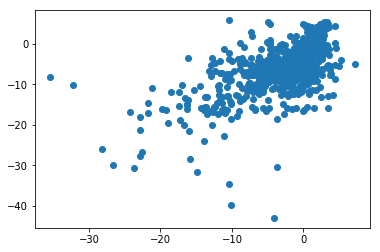

In [59]:
plt.scatter(initial_preds, expt)

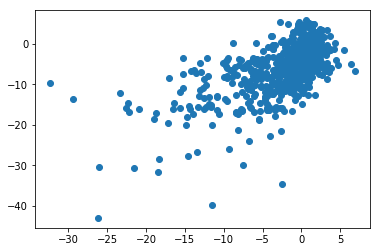

In [60]:
plt.scatter(final_preds, expt, )

In [61]:
c = np.zeros(len(mols))
c[train_inds] = 1

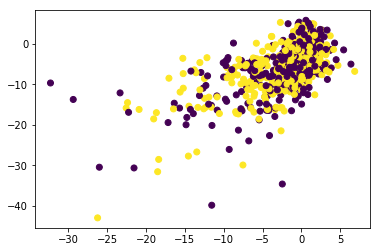

In [62]:
plt.scatter(final_preds, expt, c=c)

In [63]:
def rmse(x,y):
    return np.sqrt(np.mean((x-y)**2))

In [64]:
rmse(initial_preds, expt), rmse(final_preds, expt)

(6.1916951556733215, 6.484371500544675)

In [65]:
rmse(initial_preds[train_inds], expt[train_inds]), rmse(final_preds[train_inds], expt[train_inds])

(6.282418466150152, 6.281354132393313)

(-40, 10)

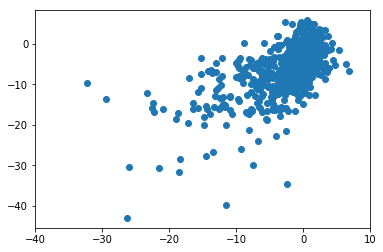

In [66]:
plt.scatter(final_preds, expt, )
plt.xlim(-40,10)

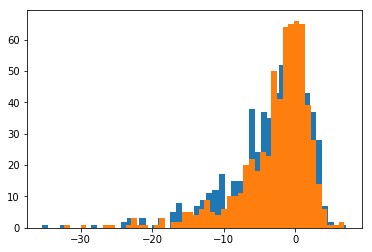

In [67]:
plt.hist(initial_preds, bins=50);
plt.hist(final_preds, bins=50);